In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt

from haversine_dist import calc_dist_lat_lon

In [2]:
def get_total_area(loc1, loc2, loc3, loc4):
    '''
      loc1-4 should be the bbox of interest. Should go clockwise starting from top left
      loc1 = top left
      loc2 = top right
      loc3 = bottom right
      loc4 = bottom left
    '''
    
    [lat1, lon1] = loc1
    [lat2, lon2] = loc2
    [lat3, lon3] = loc3
    [lat4, lon4] = loc4
    
    ##Calculate the haversine dist between all the points:
    ##loc1 to loc2 (width)
    width = calc_dist_lat_lon(lat1, lon1, lat2, lon2)
    ##loc2 to loc 3 (height)
    height = calc_dist_lat_lon(lat2, lon2, lat3, lon3)
    
    print ("width (km): ", width)
    print ("height (km) ", height)
    
    total_area = height*width
    print ("total area in km: ", total_area)
    
    ##5 knots = 9.26 km/hr
    
    total_search_days = total_area/(9.26*24)
    total_search_hours = total_area/9.26
    
    print (total_area/(9.26*24) % 24)
    print ("total search time (days): ", total_search_days)
    print ("total search time (hours): ", total_search_hours)

In [144]:
##Visualize the current maps

##get bbox
##get those coordiantes from the netcdf file at all depths
##Filter out the currents that are greater than 9999999
##visualize those currents at each depth

def visualize_currents(loc1, loc2, loc3, loc4, x_flat, y_flat, zfilter, visualize=True):
    min_lat = min(loc1[0], loc2[0], loc3[0], loc4[0])
    max_lat = max(loc1[0], loc2[0], loc3[0], loc4[0])
    min_lon = min(loc1[1], loc2[1], loc3[1], loc4[1])
    max_lon = max(loc1[1], loc2[1], loc3[1], loc4[1])
    
    print ("max_lat: ", max_lat)
    print ("min_lat: ", min_lat)
    print ("max_lon: ", max_lon)
    print ("min_lon: ", min_lon)
    
    ##get the idx values from lat, lon arrays
    lon_idx = np.where((lon[:]>=min_lon) & (lon[:]<=max_lon))
    lat_idx = np.where((lat[:]>=min_lat) & (lat[:]<=max_lat))
    
    print ("lon_idx: ", lon_idx)
    print ("lat_idx: ", lat_idx)
    
    print("lon: ", lon[:][lon_idx[0][0]-1:lon_idx[0][-1]+2])
    print("lat: ", lat[:][lat_idx[0][0]-1:lat_idx[0][-1]+2])
    
    lon_len = len(lon[:][lon_idx[0][0]-1:lon_idx[0][-1]+2])
    lat_len = len(lat[:][lat_idx[0][0]-1:lat_idx[0][-1]+2])
    
    print ("lon_len: ", lon_len)
    print ("lat_len: ", lat_len)
    
    
    ##Use those idx values to get depth values from u and v
    ##U and V are read-only(?). Hence, copy the values
    u_area = u[0, :, lat_idx[0][0]-1:lat_idx[0][-1]+2, lon_idx[0][0]-1:lon_idx[0][-1]+2].copy()
    v_area = v[0, :, lat_idx[0][0]-1:lat_idx[0][-1]+2, lon_idx[0][0]-1:lon_idx[0][-1]+2].copy()
    
#     print ('u_area: ', u_area)
    
    ##Filter out the currents that are greater than -9999:
    neg_values = u_area <-800
    u_area[neg_values] = 0.000
    v_area[neg_values] = 0.000
    
    ##make into vector
    uv_area = np.hypot(u_area, v_area)
    min_uv_area = np.amin(uv_area)
    max_uv_area = np.amax(uv_area)
    
    ##Visualize
    ##lat is the y-axis, lon is the x-axis
    
    if visualize == True:
        for d in range(depth.shape[0]):
            u_slice = u_area[d,:,:]
            v_slice = v_area[d,:,:]

            X = np.empty((lat_len, lon_len))
            Y = np.empty((lon_len, lat_len))
            
            X[:] = lon[:][lon_idx[0][0]-1:lon_idx[0][-1]+2]
            Y[:] = lat[:][lat_idx[0][0]-1:lat_idx[0][-1]+2]
            Y = Y.transpose()

            fig3, ax3 = plt.subplots(figsize=(10,10))
            
            ##contour map
            CS = ax3.contour(x_flat, y_flat, zfilter)
            ax3.clabel(CS, inline=1, fontsize=12)
            
            ax3.set_title("Current vector field at depth={0}".format(depth[d]))
            im = ax3.scatter(X,Y, color='b', s=15)
            im3 = ax3.quiver(X, Y, u_slice, v_slice, uv_area[d,:,:], scale=1)
            
            ax3.set_xlim([min_lon-0.1, max_lon+0.05])
            ax3.set_ylim([min_lat-0.1, max_lat+0.05])
            
            cbar1 = fig3.colorbar(im3)
            im3.set_clim(min_uv_area, max_uv_area)
            
#     return u_area, v_area, uv_area
    return u_area, v_area, uv_area

In [5]:
##Coordinates
##Here we use lajolla_close to coronado_close:
loc1 = [32.858, -117.466]
loc2 = [32.858, -117.265]
loc3 = [32.66, -117.265]
loc4 = [32.66, -117.466]
coords = np.array([loc1, loc2, loc3, loc4])
get_total_area(loc1, loc2, loc3, loc4)

width (km):  18.774546561025755
height (km)  22.01659547562253
total area in km:  413.35159687234415
1.8599333912542482
total search time (days):  1.8599333912542482
total search time (hours):  44.63840139010196


In [6]:
##Get topological data
socal_topo_data = netcdf.NetCDFFile('/home/msit/Desktop/southern_calif_crm_v1.nc')
x_topo = socal_topo_data.variables['x'][:]
y_topo = socal_topo_data.variables['y'][:]
z_topo = socal_topo_data.variables['z'][:]

socal_topo_data.close()

/usr/lib/python3/dist-packages/scipy/io/netcdf.py:297: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


In [130]:
##Get the hydrodynamic data
file2read = netcdf.NetCDFFile('/home/msit/Desktop/ca_subCA_das_2020010615.nc')

u = file2read.variables['u']
v = file2read.variables['v']
print ("u shape: ", u.shape)
print ("v shape: ", v.shape)
depth = file2read.variables['depth']

lon = file2read.variables['lon']
lon = lon[:]-360
lat = file2read.variables['lat']

file2read.close()

u shape:  (1, 14, 391, 351)
v shape:  (1, 14, 391, 351)


/usr/lib/python3/dist-packages/scipy/io/netcdf.py:297: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


/home/msit/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  after removing the cwd from sys.path.


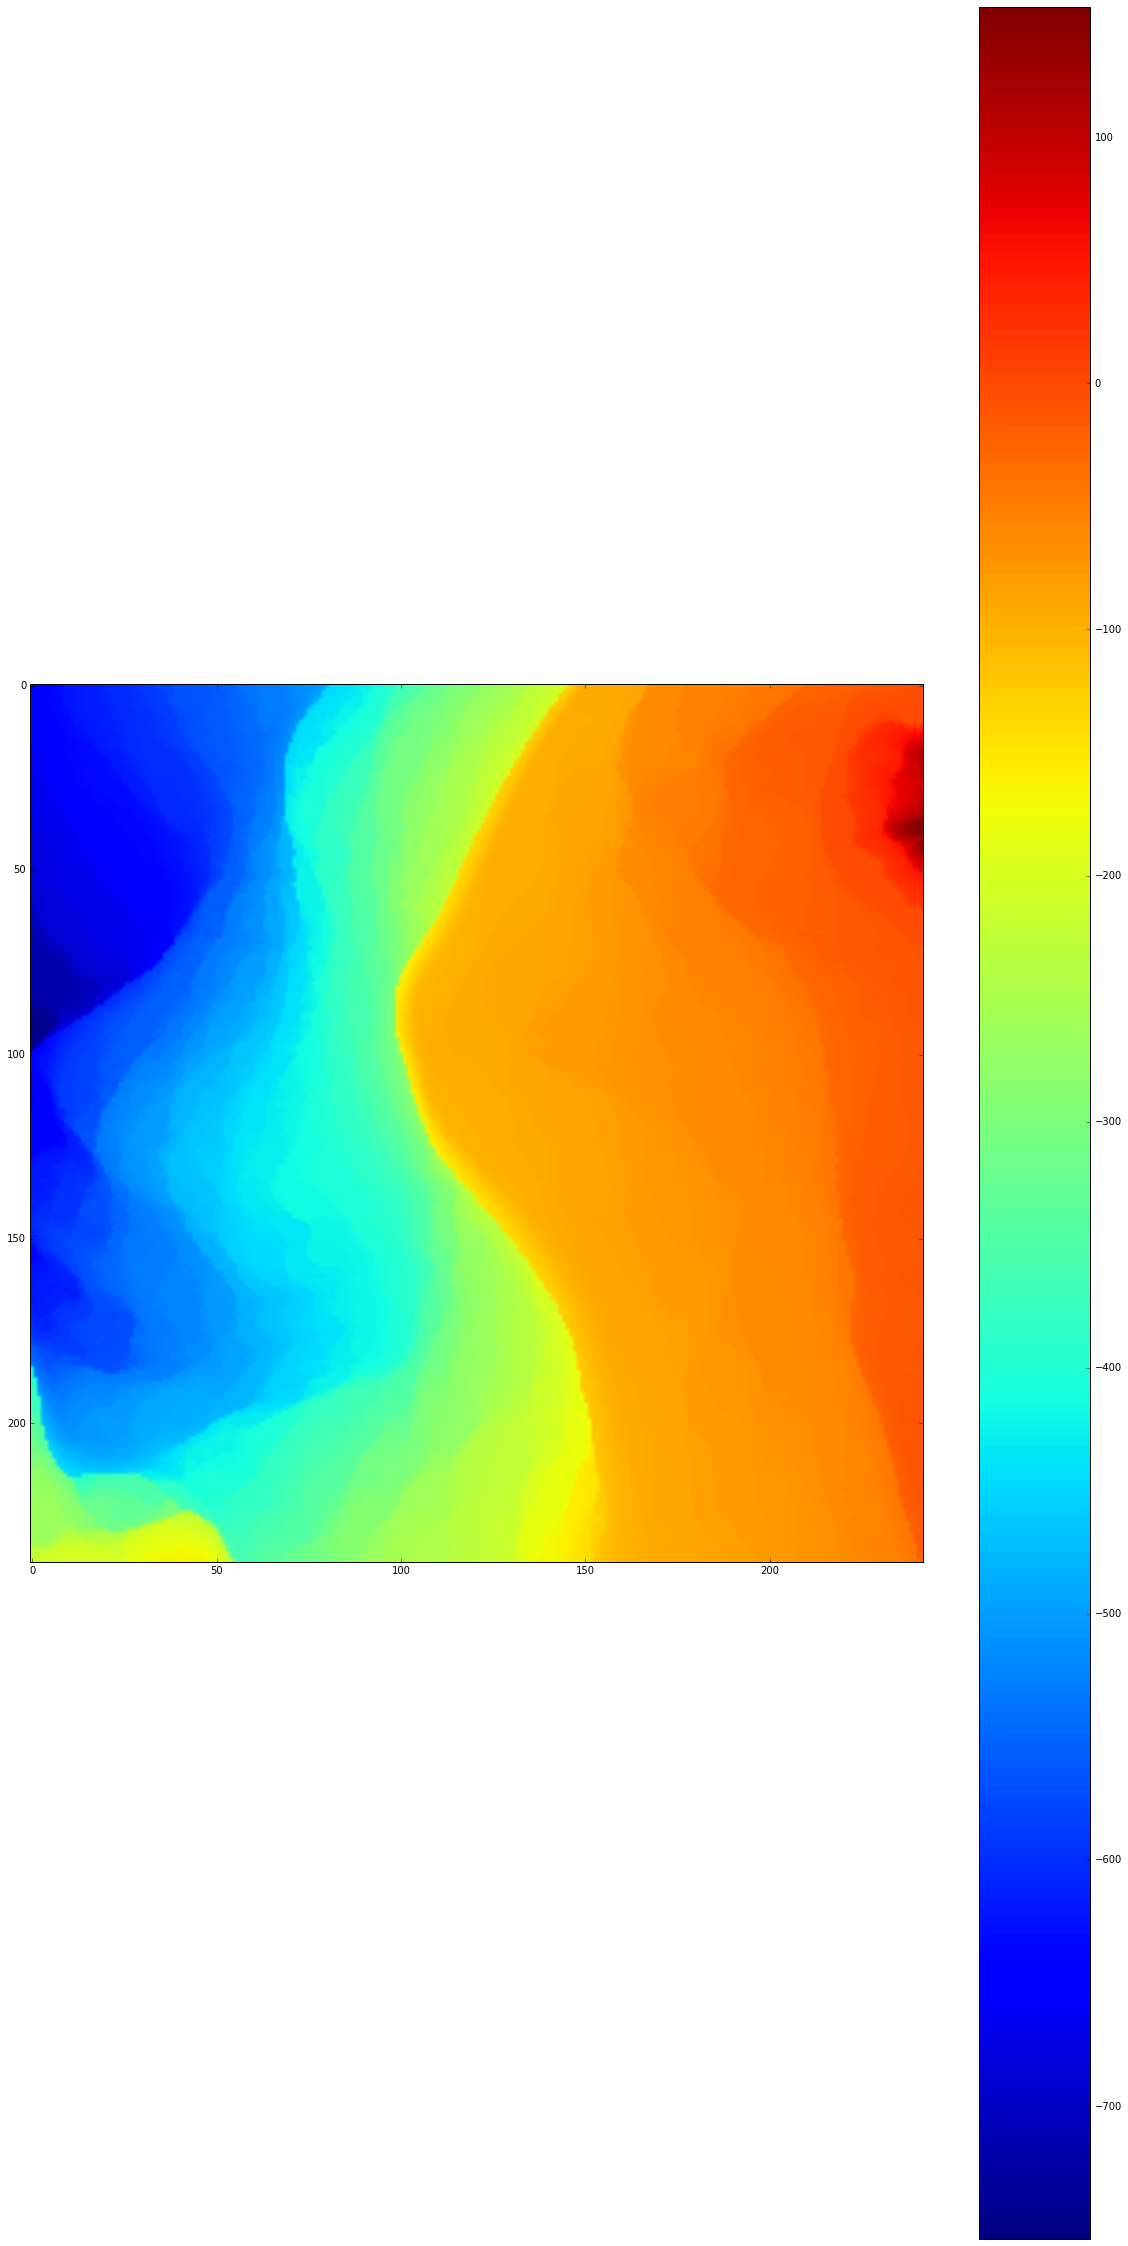

In [8]:
##Show the topological data
xfilter = np.argwhere((x_topo <= max(coords[:,1])) & (x_topo >= min(coords[:,1])))
yfilter = np.argwhere((y_topo >= min(coords[:,0])) & (y_topo <= max(coords[:,0])))
zfilter = z_topo[yfilter[0]:yfilter[-1]+1, xfilter[0]:xfilter[-1]+1]

xclip = x_topo[xfilter].flatten()
yclip = y_topo[yfilter].flatten()
x_flat, y_flat = np.meshgrid(xclip, yclip)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 40))
im = ax.imshow(np.flipud(zfilter))
cbar = fig.colorbar(im)

<a list of 6 text.Text objects>

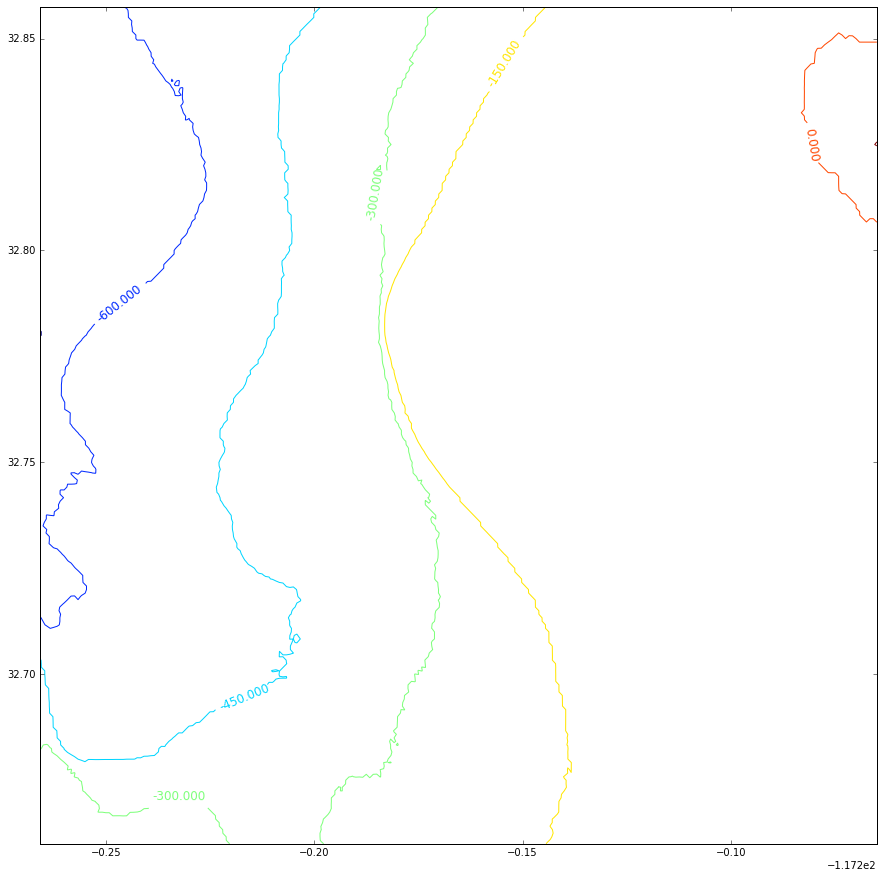

In [9]:
##Show the contour map
fig3, ax3 = plt.subplots(figsize=(15,15))
CS = ax3.contour(x_flat, y_flat, zfilter)
ax3.clabel(CS, inline=1, fontsize=12)
# plt.show()

max_lat:  32.858
min_lat:  32.66
max_lon:  -117.265
min_lon:  -117.466
lon_idx:  (array([335, 336, 337, 338, 339, 340, 341]),)
lat_idx:  (array([46, 47, 48, 49, 50, 51]),)
lon:  [-117.47999573 -117.44999695 -117.41999817 -117.38999939 -117.36000061
 -117.33000183 -117.30000305 -117.27000427 -117.24000549]
lat:  [ 32.64999771  32.68000031  32.70999908  32.73999786  32.77000046
  32.79999924  32.82999802  32.86000061]
lon_len:  9
lat_len:  8


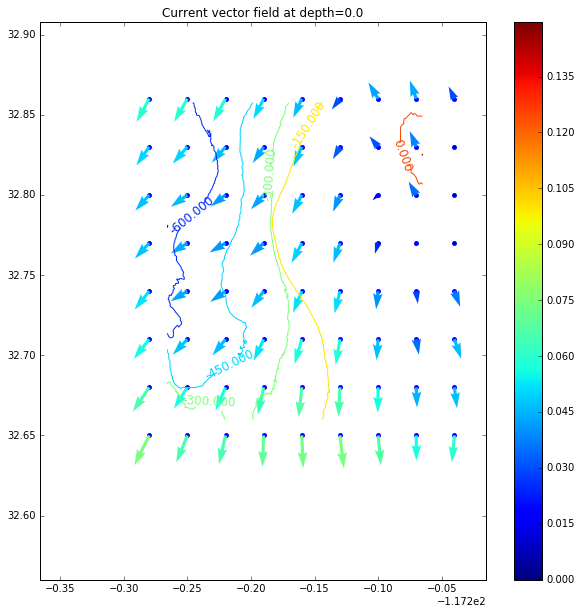

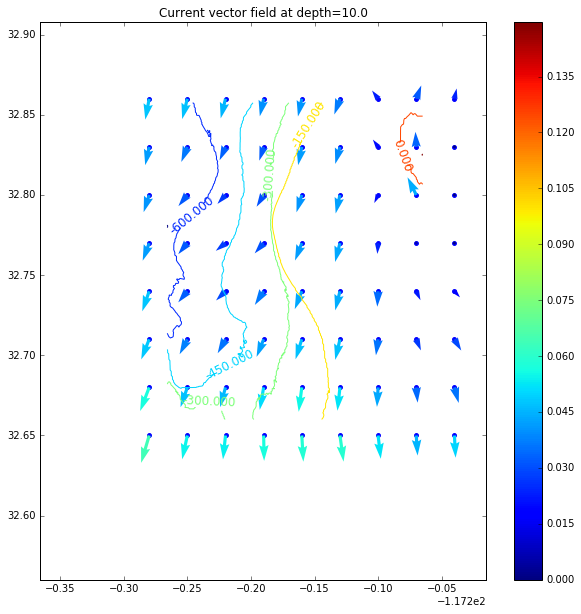

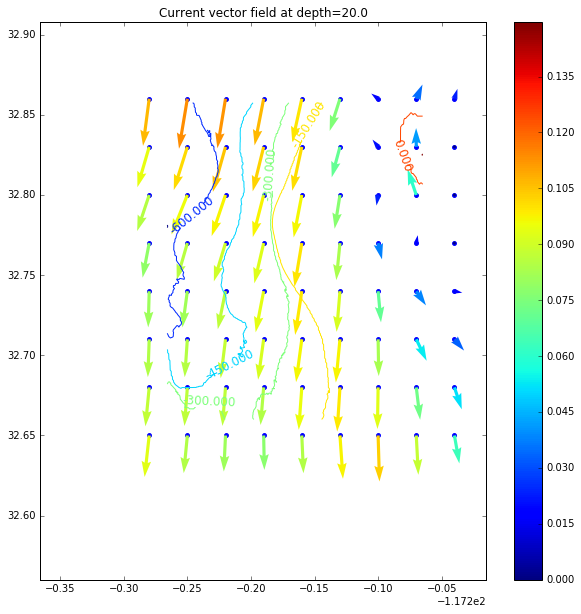

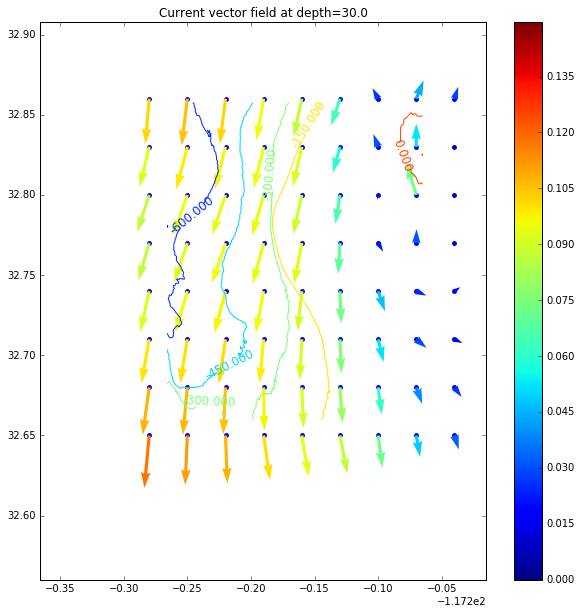

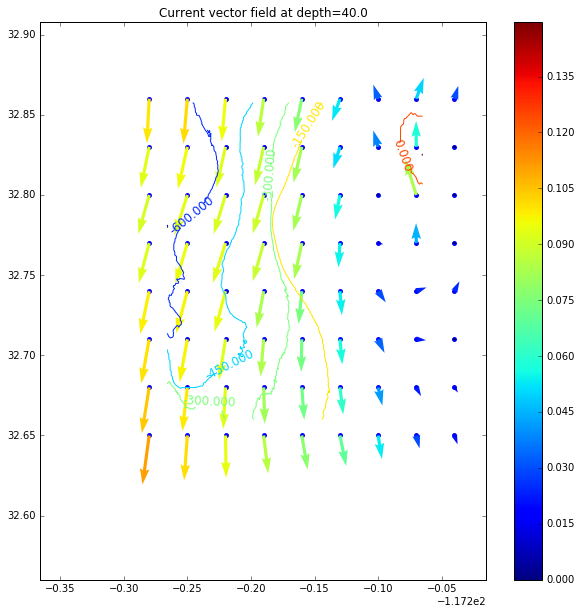

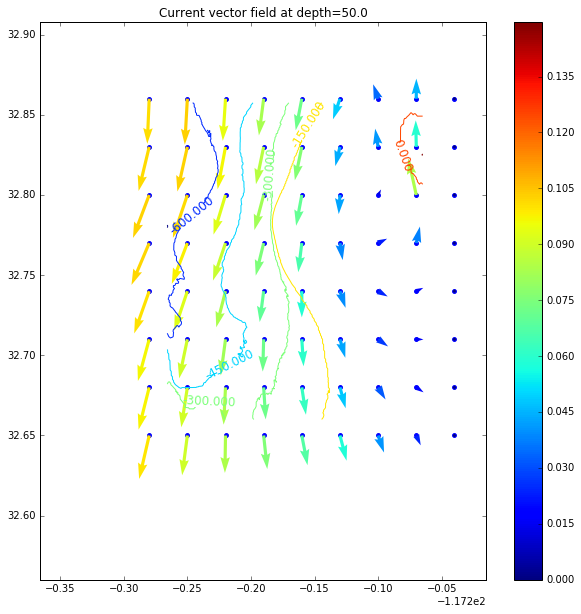

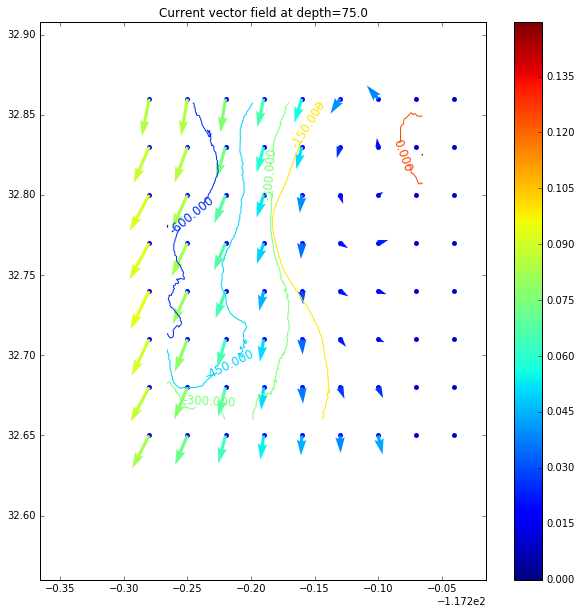

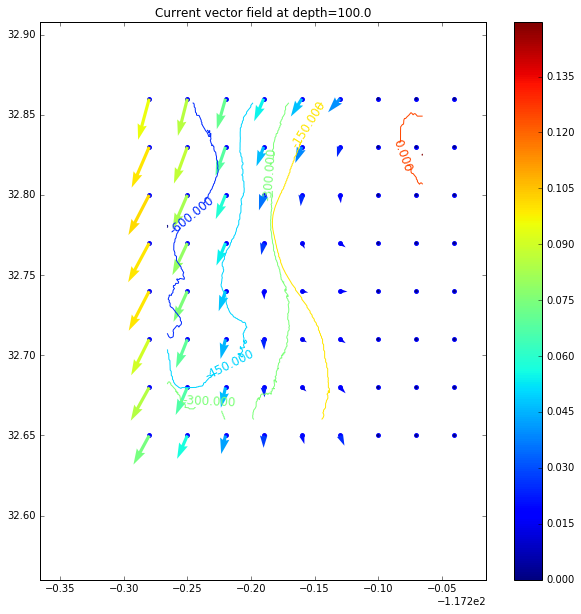

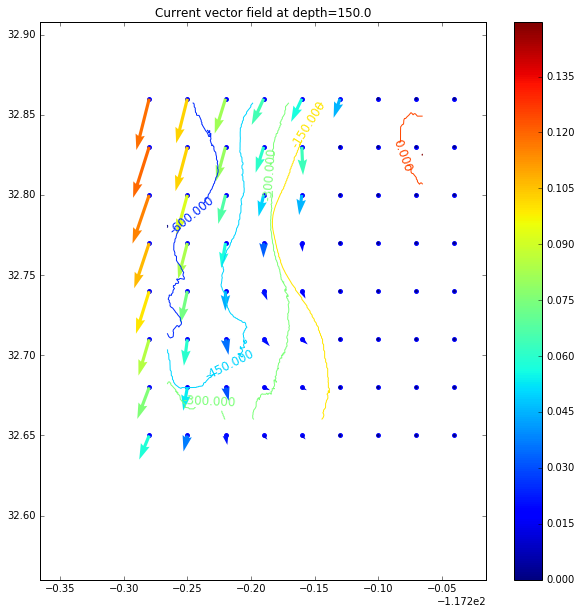

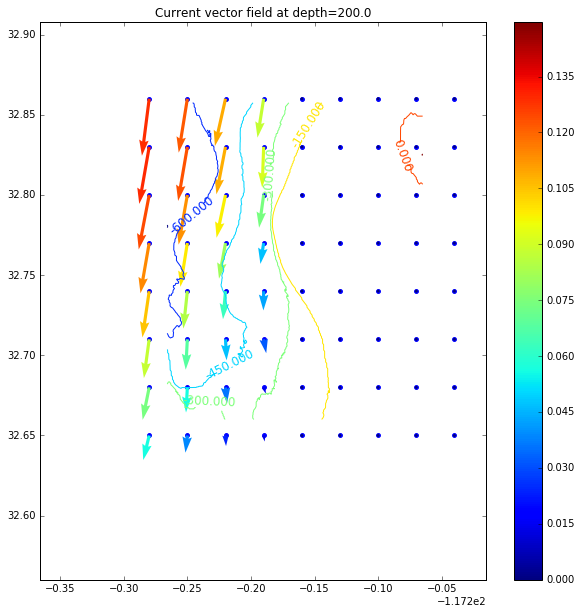

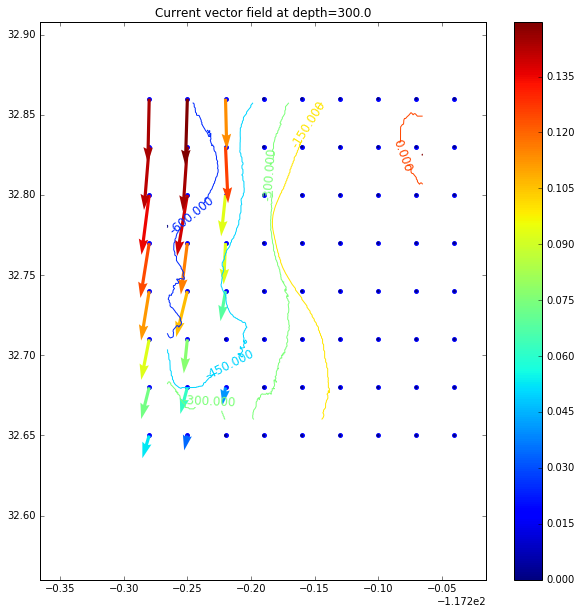

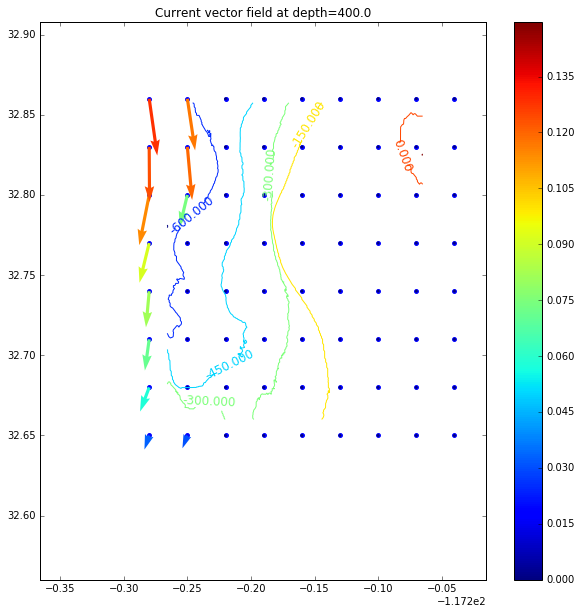

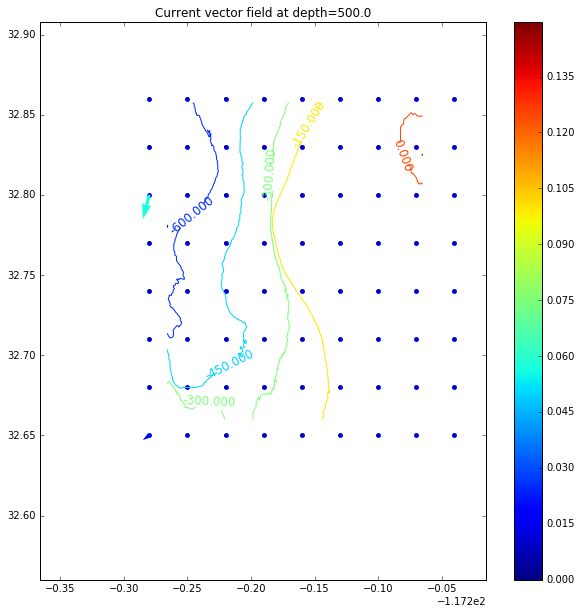

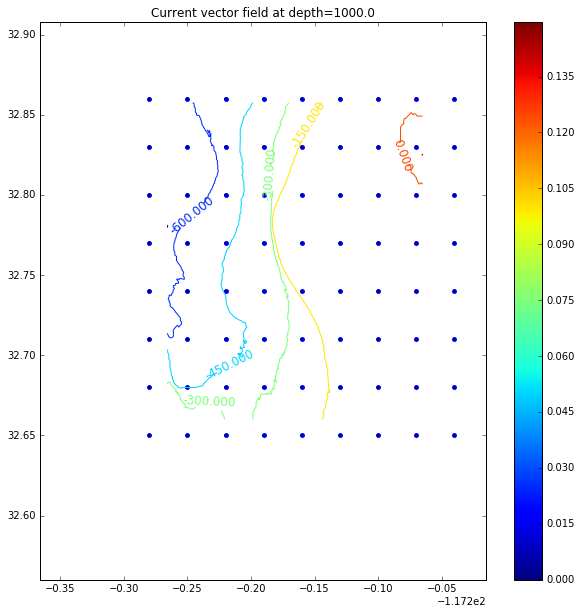

In [145]:
##Show the hydrodynamic data
u_area, v_area, uv_area = visualize_currents(loc1, loc2, loc3, loc4, x_flat, y_flat, zfilter)